<a href="https://colab.research.google.com/github/martell-n-tardy/Risk-Prediction-Models-for-Type-2-Diabetes/blob/main/Preprocessing_%26_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preprocessing & Training: BRFSS data - By Martell Tardy, M.S.**

# Load packages

In [ ]:
import pandas as pd
import numpy as np
from numpy import mean,std
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score,accuracy_score

# Load data

In [ ]:
#mount Drive and grant access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read in data and save as variable df
df = pd.read_csv('/content/drive/MyDrive/SPRINGBOARD/CAPSTONE 3/BRFSS Data/Processed/finalfeats_2015.csv')
df

,state,prediabetes,age,weight,blood_pressure_meds,general_health,fruit_juice,pneumonia_shot,race,cholesterol_check,high_cholesterol,height,cognitive_decline,alcohol,fruit,kidney_health,physical_health,sex,shingles_vaccine,other_veg,green_veg,cigarettes,employment,sodium,type2_diabetes
0,0.169308,0.074352,0.171900,0.230504,0.266355,0.296992,0.112202,0.212869,0.119337,0.173159,0.225517,0.128326,0.111739,0.180150,0.128318,0.119388,0.214877,0.123972,0.124384,0.128453,0.127072,0.097530,0.292054,0.125268,0
1,0.169308,0.074352,0.113065,0.115439,0.053195,0.089652,0.112202,0.076920,0.119337,0.027878,0.083594,0.128326,0.264431,0.180150,0.128318,0.119388,0.094261,0.123972,0.124384,0.128453,0.127072,0.113719,0.134980,0.098757,0
2,0.169308,0.074352,0.218709,0.056077,0.053195,0.296992,0.122087,0.119395,0.119337,0.173159,0.225517,0.122700,0.111739,0.113072,0.123805,0.119388,0.214877,0.123972,0.124384,0.125341,0.123034,0.113719,0.200757,0.125268,0
3,0.169308,0.074352,0.171900,0.115439,0.266355,0.296992,0.153444,0.212869,0.119337,0.173159,0.225517,0.128326,0.264431,0.180150,0.128318,0.119388,0.277691,0.123972,0.124384,0.128453,0.127072,0.113719,0.292054,0.098757,0
4,0.169308,0.074352,0.171900,0.056077,0.053195,0.296992,0.122087,0.212869,0.119337,0.173159,0.083594,0.128326,0.164604,0.180150,0.128318,0.119388,0.256335,0.123972,0.124384,0.128453,0.127072,0.113719,0.292054,0.198241,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,0.201110,0.151725,0.218709,0.043446,0.266355,0.296992,0.112202,0.076920,0.140718,0.173159,0.225517,0.128326,0.164604,0.180150,0.147174,0.119388,0.094261,0.123972,0.124384,0.128453,0.175943,0.113719,0.200757,0.198241,1
441452,0.201110,0.151725,0.000065,0.115439,0.053195,0.089652,0.112202,0.076920,0.140718,0.173159,0.083594,0.128326,0.111739,0.180150,0.128318,0.119388,0.094261,0.123972,0.124384,0.128453,0.127072,0.113719,0.070031,0.198241,0
441453,0.201110,0.151725,0.218709,0.230504,0.266355,0.296992,0.122087,0.119395,0.140718,0.173159,0.225517,0.128326,0.111739,0.093876,0.123805,0.119388,0.094261,0.123972,0.124384,0.125341,0.123034,0.189050,0.200757,0.125268,0
441454,0.201110,0.151725,0.113065,0.056077,0.266355,0.089652,0.112202,0.076920,0.140718,0.173159,0.083594,0.122700,0.164604,0.180150,0.128318,0.119388,0.094261,0.134777,0.124384,0.128453,0.127072,0.113719,0.134980,0.198241,0


In [ ]:
#confirm all missing values are imputed
df.columns[df.isnull().any()]

Index([], dtype='object')

# Preparing the data

In [ ]:
df['type2_diabetes'].value_counts()

0    384708
1     56748
Name: type2_diabetes, dtype: int64

1 = 6.77 percent of total observations. This is greater than 5%, which means it is okay to use, but let's address this imbalance with the LightGBM parameter 'sample_pos_weight'. The parameter sample_pos_weight = number of negative samples / number of positive samples. In this case that is sample_pos_weight = 384708 / 56748, which is the 6.77 or 6.8 percent we identified.

In [ ]:
#copy of df as appropriate type for LightGBM
df1 = df

#split data into X and y
X,y = df1.drop(['type2_diabetes'], axis = 1), df1['type2_diabetes']
#split data 70/30 train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# LightGBM ensemble for binary classification

The goal of a binary classification problem is to create a machine learning model that makes a prediction in situations where the thing to predict can take one of just two possible values. For this study, we want to predict whether a person is diabetic(1) or not diabetic(2) based on the 24 predictor variables selected.

## baseline model

To create a baseline model of the LightGBM algorithm we will use its default parameters to see how it performs on the dataset. We will then evaluate the model using repeated stratified k-fold cross-validation with three repeats and 10 folds. We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.

**Note:** Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision.

In [ ]:
#define the model
model = lgb.LGBMClassifier()

#evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

#report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.908 (0.001)


We can see from the outcome the LightGBM algorithm with default hyperparameters achieves a **classification accuracy of about 90.8%** on the entire dataset. Therefore, we will use this baseline of performance that we want to out perform. 

Now, let's see improve the classification accuracy by exploring this algorithm's hyperparameters.

## hyperparameter tuning: number of trees

An important hyperparameter for the LightGBM ensemble algorithm is the number of decision trees used in the ensemble.

Recall that decision trees are added to the model sequentially in an effort to correct and improve upon the predictions made by prior trees. As such, more trees are often better. The number of trees can be set via the “n_estimators” argument and defaults to 100.

The code below explores the effect of the number of trees with values between 10 to 5,000.

>10 0.892 (0.001)
>50 0.906 (0.001)
>100 0.908 (0.001)
>500 0.909 (0.001)
>1000 0.908 (0.001)
>5000 0.906 (0.001)


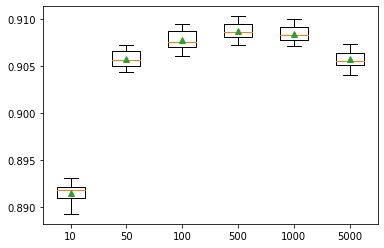

In [ ]:
#get a list of models to evaluate
def get_models():
	models = dict()
	trees = [10, 50, 100, 500, 1000, 5000]
	for n in trees:
		models[str(n)] = LGBMClassifier(n_estimators=n)
	return models

#evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
#get the models to evaluate
models = get_models()

#evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

From the output we can see that that performance improves on this dataset until about 500 trees, after which performance appears to level off.

## hyperparameter tuning: tree depth

Varying the depth of each tree added to the ensemble is another important hyperparameter for gradient boosting.

The tree depth controls how specialized each tree is to the training dataset: how general or overfit it might be. Tree depth is controlled via the “max_depth” argument and defaults to an unspecified value as the default mechanism for controlling how complex trees are, is to use the number of leaf nodes.

There are two main ways to control tree complexity: the max depth of the trees and the maximum number of terminal nodes (leaves) in the tree. In this case, we are exploring the number of leaves so we need to increase the number of leaves to support deeper trees by setting the “num_leaves” argument.

The code belows explores tree depths between 1 and 10 and the effect on model performance.

>1 0.883 (0.001)
>2 0.895 (0.001)
>3 0.900 (0.001)
>4 0.904 (0.001)
>5 0.906 (0.001)
>6 0.907 (0.001)
>7 0.907 (0.001)
>8 0.908 (0.001)
>9 0.908 (0.001)
>10 0.908 (0.001)


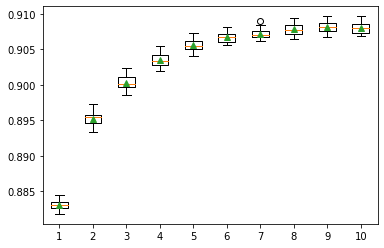

In [ ]:
#get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,11):
		models[str(i)] = LGBMClassifier(max_depth=i, num_leaves=2**i)
	return models
 
#evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
#get the models to evaluate
models = get_models()

#evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
 
#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

From the output, we can see that performance improves clearly with tree depth to level 8. However, in the box and whisker plot performance appears to slightly continue to improve with tree depth to level 9, after which performance begins to sit reasonably flat.

**Note:** the 'num_leaves' parameter was explored as well, resulting in a value of 2^9 = 512 for parameter 'num_leaves' instead of the default value of 31.

## hyperparameter tuning: learning rate

Learning rate controls the amount of contribution that each model has on the ensemble prediction. Smaller rates may require more decision trees in the ensemble. The learning rate can be controlled via the “learning_rate” argument and defaults to 0.1.

The code below explores the learning rate and compares the effect of values between 0.0001 and 1.0.

>0.0001 0.871 (0.000)
>0.0010 0.871 (0.000)
>0.0100 0.890 (0.001)
>0.1000 0.908 (0.001)
>1.0000 0.898 (0.012)


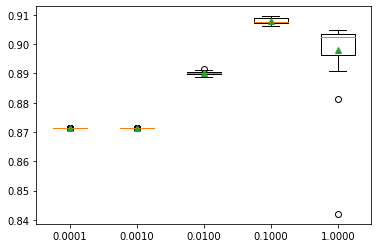

In [ ]:
#get a list of models to evaluate
def get_models():
	models = dict()
	rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
	for r in rates:
		key = '%.4f' % r
		models[key] = LGBMClassifier(learning_rate=r)
	return models
 
#evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
#get the models to evaluate
models = get_models()

#evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
 
#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

From the output we can see that a larger learning rate results in better performance on this dataset. In the box and whisker plot we can see the general trend of increasing model performance with the increase in learning rate all the way to the values of 1.0, after which performance appears to level off.

## hyperparameter tuning: boosting type

A feature of LightGBM is that it supports a number of different boosting algorithms, referred to as boosting types.

The boosting type can be specified via the “boosting_type” argument and take a string to specify the type. The options include:

- **‘gbdt‘:** Gradient Boosting Decision Tree (GDBT).
- **‘dart‘:** Dropouts meet Multiple Additive Regression Trees (DART).
- **‘goss‘:** Gradient-based One-Side Sampling (GOSS).

The default is GDBT, which is the classical gradient boosting algorithm.

>gbdt 0.908 (0.001)
>dart 0.905 (0.001)
>goss 0.908 (0.001)


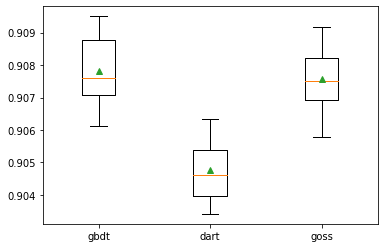

In [ ]:
#get a list of models to evaluate
def get_models():
	models = dict()
	types = ['gbdt', 'dart', 'goss']
	for t in types:
		models[t] = LGBMClassifier(boosting_type=t)
	return models
 
#evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
#get the models to evaluate
models = get_models()

#evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
 
#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

From the output we can see that the gbdt and goss boosting method performed equally. However, in the box and whisker plot we can see that the default boosting method (gbdt) performed slightly better than the other two techniques that were evaluated.

# Summary

After establishing a baseline model performance of 90.8% using the default parameters for a LightGBM binary classification model, we were then able to explore hypertuning to improve the performance of the model. After focusing our efforts on the parameters number of trees (n_estimators), tree depth (max_depth), learning rate, and boosting type we were able to confirm the best parameters in terms of performance as 500 (default = 100), 9 (default = -1), 0.1 (default value), and gbdt (default value) respectively. Next, we will build a new LightGBM binary classification model with these parameters and explore it's performance.